TO DO / next steps:
* agregar reporte de train MAE para ver si estamos en overfitting con el modelo final
* encapsular pasos generales en clases / modulo para uso comun entre experimentos y backend
* por que se ve menos loss de validacion que de train?
  * Más epochs 
  * invertir el train / val / test, buscar train de tras para adalente, despues val o test y despues el que resta
* ver si conviene usar `generators` (ver proyecto de EEG prediction)
* mejorar nombre variables en funcion ```series_to_supervised```
* encontrar buenos parametros en early stopping
* mejores parametros para fitting
* leer desde timescale db
* diseño de la red "optimizable" (~neuroevolución)



Recursos interesantes:

* https://www.liip.ch/en/blog/time-series-prediction-a-short-comparison-of-best-practices
* https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

In [33]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model, model_from_json
import pickle
import glob

from geolomas.configuration import LSTMTrainingScriptConfig

from geolomas.data import read_time_series_from_csv
from geolomas.feature import (
    get_dataset_from_series,
    get_interest_variable
)
from geolomas.model_hyperopt import (
    get_lstm_nnet_opt
)
from geolomas.model import (train_val_test_split)


import ipdb

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    #df = DataFrame(data)
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        #names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        names += [('%s(t-%d)' % (var_name, i)) for var_name in df.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (var_name)) for var_name in df.columns]
        else:
            names += [('%s(t+%d)' % (var_name, i)) for var_name in df.columns]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [ ]:

# design network
model = Sequential()
#model.add(LSTM(2*n_hours, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(2*n_hours, input_shape=(n_hours, 1),return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(3*n_hours, return_sequences=True)) 
model.add(Dropout(rate=0.2))
model.add(LSTM(2*n_hours)) 
model.add(Dropout(rate=0.2))
model.add(Dense(1))

#model_loss = 'mae'
model_loss = 'mean_squared_error'

model.compile(loss=model_loss, optimizer='adam')
#model.compile(loss='model_loss', optimizer='adam', metrics=['accuracy'])

# fit network
# que corte despues de no mejorar mucho
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min',restore_best_weights=True)
# que use el mejor modelo

checkpoint = ModelCheckpoint(out_model_name, save_best_only=True, monitor='val_loss', mode='min',verbose=2)

history = model.fit(train_X, train_y, epochs=100, validation_data=(val_X, val_y), verbose=1, shuffle=False,callbacks=[checkpoint,early_stopping])
print(model.summary())

with open('history.pickle', 'wb') as file_pi:
    pickle.dump(history, file_pi)


../models/esp:10_eps:5_loss:mean_squared_error_opt:adam_pstps:3_sensor:A620_var:temp_basenet:4.4_midnet:4.2_hyperoptpars:[2, 3][2, 3][0.1, 0.8]2_hyperopt_history_2020-02-25_18:03:51.pickle


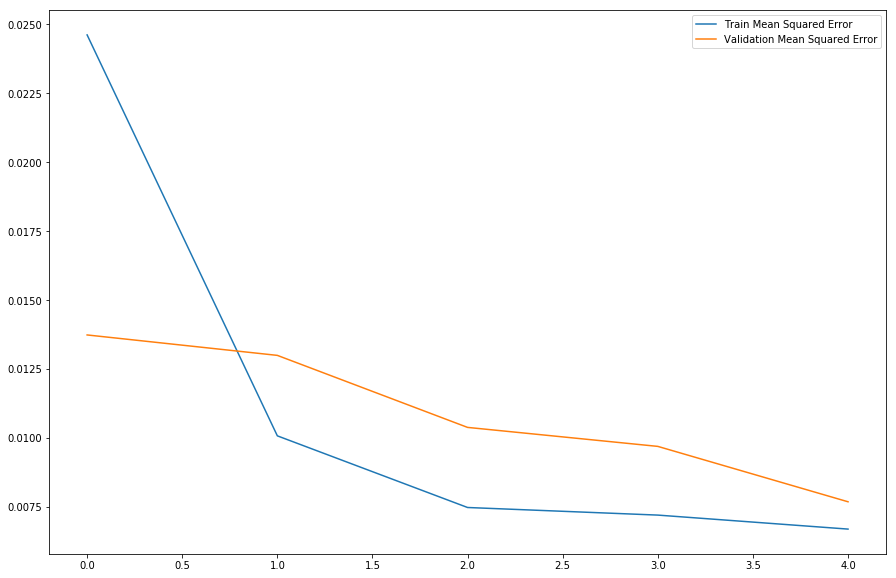

In [69]:
# plot history
read_prev = True

filename_history = glob.glob('../models/*_hyperopt_history_*.pickle')[-1]
#filename_history = '../models/esp:10_eps:2_loss:mean_squared_error_opt:adam_pstps:3_sensor:A620_var:temp_basenet:4.4_midnet:4.2_hyperoptpars:[1, 2, 3][2, 3][0.1, 0.8]3_hyperopt_history_2020-02-25_10:13:29.pickle'

print(filename_history)

if read_prev:
    try:
        del history
    except:
        pass
    with open(filename_history, 'rb') as file_pi:
        history = pickle.load(file_pi)

plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label='Train Mean Squared Error')
plt.plot(history.history['val_loss'], label='Validation Mean Squared Error')
plt.legend()
plt.savefig('traininig_curve.png')
plt.show()

In [70]:

out_model_name = glob.glob('../models/*_hyperopt_model_*.hdf5')[-1]
print(out_model_name)
#out_model_name = '../models/esp:10_eps:2_loss:mean_squared_error_opt:adam_pstps:3_sensor:A620_var:temp_basenet:4.4_midnet:4.2_hyperoptpars:[1, 2, 3][2, 3][0.1, 0.8]3_hyperopt_model_2020-02-25_10:13:29.hdf5'
model_hyper = load_model(out_model_name)
print(model_hyper.summary())


../models/esp:10_eps:5_loss:mean_squared_error_opt:adam_pstps:3_sensor:A620_var:temp_basenet:4.4_midnet:4.2_hyperoptpars:[2, 3][2, 3][0.1, 0.8]2_hyperopt_model_2020-02-25_18:03:51.hdf5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 3, 9)              396       
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 9)              0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 3, 6)              384       
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 6)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 6)              312       
_________________________________________________________________
d

In [61]:
layer_idx = 2
model_hyper.layers[layer_idx].input_shape

(None, 3, 9)

In [71]:

out_model_name_simple = '../models/esp:10_eps:2_loss:mean_squared_error_opt:adam_pstps:3_sensor:A620_var:temp_basenet:4.4_midnet:4.2_model_2020-02-25_10:44:21.hdf5'
model_simple = load_model(out_model_name_simple)
print(model_simple.summary())
model_simple.layers[3].rate

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 6)              192       
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 6)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 6)              312       
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 6)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 6)              312       
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 6)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6)                

0.2

In [72]:
# load dataset usando geolomas
config_file = '../config_train_lstm_temp.json'
script_config = LSTMTrainingScriptConfig(config_file)

n_past_steps = script_config.n_past_steps
input_csv = script_config.input_csv

date_col = script_config.date_col
hr_col = script_config.hr_col
target_var = script_config.numeric_var
sensor_var = script_config.sensor_var
sensor = script_config.target_sensor

# read the raw data
input_csv_nb = '../{}'.format(input_csv)
raw_dataset = read_time_series_from_csv(input_csv_nb,date_col,hr_col,target_var,sensor_var)
raw_dataset.head()

# get the time series dataset
time_series_dset = get_interest_variable(raw_dataset,sensor_var,date_col,hr_col,target_var,sensor)
time_series_dset.head()

# get the final dataset
sup_dataset,scaler = get_dataset_from_series(time_series_dset,n_past_steps)
print(scaler)
sup_dataset.head()

# split the dataset in train , test and validation
n_features = time_series_dset.shape[1]
dataset_splits = train_val_test_split(sup_dataset,n_past_steps,n_features,target_var)

train_X = dataset_splits['trainset']['X']
test_X = dataset_splits['testset']['X']

train_y = dataset_splits['trainset']['y']
test_y = dataset_splits['testset']['y']

read dataset of shape (160584, 3)
MinMaxScaler(copy=True, feature_range=(0, 1))
Sampleamos datasets de futuro a pasado
(96348, 3) 96348 (96348,)
(96348, 3, 1) (96348,) (32116, 3, 1) (32116,) (32117, 3, 1) (32117,)


In [75]:
# make a prediction
def make_prediction(model):
#    try:
#        del model
#    except:
#        pass

#    model = model_hyper
    print(model.summary())

    yhat = model.predict(test_X)
    tr_yhat = model.predict(train_X)

    # por que reshapeamos aca?
    test_X_2d = test_X.reshape((test_X.shape[0], n_past_steps*n_features))
    train_X_2d = train_X.reshape((train_X.shape[0], n_past_steps*n_features))
    # invert scaling for forecast
    # test
    # Por que lo que hace es armar una matrix n_samples,6 con una fila por cada datapoint con la primera columna con la prediccion y las otras las features?
    inv_yhat = concatenate((yhat, test_X_2d[:, -1*(n_features-1):]), axis=1)
    # afecta en algo aplicar invers_stransform sobre una sola columna que con tra la matriz?
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # train
    tr_inv_yhat = concatenate((tr_yhat, train_X_2d[:, -1*(n_features-1):]), axis=1)
    tr_inv_yhat = scaler.inverse_transform(tr_inv_yhat)
    tr_inv_yhat = tr_inv_yhat[:,0]

    # invert scaling for actual
    #test
    test_y_2d = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y_2d, test_X_2d[:, -1*(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    #train
    train_y_2d = train_y.reshape((len(train_y), 1))
    tr_inv_y = concatenate((train_y_2d, train_y_2d[:, -1*(n_features-1):]), axis=1)
    tr_inv_y = scaler.inverse_transform(tr_inv_y)
    tr_inv_y = tr_inv_y[:,0]


    # calculate MAE
    tr_mae = mean_absolute_error(tr_inv_y, tr_inv_yhat)
    print('Train MAE: %.3f' % tr_mae)
    mae = mean_absolute_error(inv_y, inv_yhat)
    print('Test MAE: %.3f' % mae)
    return inv_yhat,inv_y
    
    
predictions_hyper , inv_y = make_prediction(model_hyper)
predictions_simple , inv_y = make_prediction(model_simple)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 3, 9)              396       
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 9)              0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 3, 6)              384       
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 6)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 6)              312       
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 6)              0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 6)             

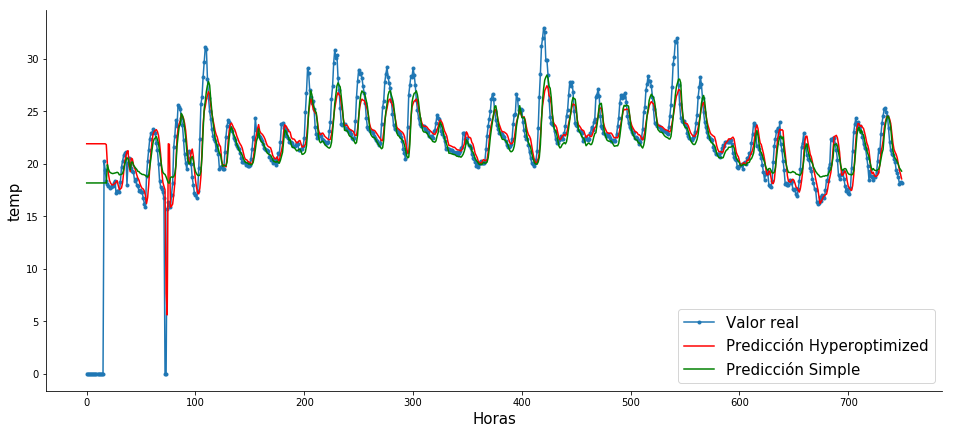

In [83]:
%matplotlib inline

def plot_predictions(real,hyper,simple):
    inv_y = real
    inv_yhat = hyper
    inv_yhat_simple = simple
    # ploting the actual and prediction together
    total_time_steps = 750
    time_steps=[x for x in range(total_time_steps)]
    plt.figure(figsize=(15,7))

    #plt.plot(time_steps, Y_test[0][:total_time_steps], marker='.', label="actual")
    #plt.plot(time_steps, test_predict[:,0][:total_time_steps], 'r', label="prediction")

    plt.plot(time_steps, inv_y[:total_time_steps], marker='.', label="Valor real")
    plt.plot(time_steps, inv_yhat[:total_time_steps], 'r', label="Predicción Hyperoptimized")
    plt.plot(time_steps, inv_yhat_simple[:total_time_steps], 'g', label="Predicción Simple")

    # plt.tick_params(left=False, labelleft=True) #remove ticks
    #plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel(target_var, size=15)
    plt.xlabel('Horas', size=15)
    plt.legend(fontsize=15)
    plt.savefig('prediction_plot.png')
    plt.show()
    
plot_predictions(inv_y,predictions_hyper,predictions_simple)

In [15]:
results_train_server = pd.read_csv('../results/A620_temp_results_2020-01-08_23:29:54.csv')
results_train_server.iloc[0]


base_nnet_config       {'last_layer': {'dropout_rate': 0.2, 'mult': 2...
early_stop_patience                                                   50
epochs                                                              1000
mid_layers_config        {'dropout_rate': 0.2, 'mult': 2, 'n_layers': 2}
model_loss                                            mean_squared_error
optimizer                                                           adam
sensor                                                              A620
target_variable                                                     temp
test_eval_time                                                   3.15708
test_mae                                                        0.875876
test_r2                                                         0.837557
train_eval_time                                                  9.89835
train_mae                                                       0.894118
train_r2                                           

In [17]:
for x in range(1,35,10):
    print(x)

1
11
21
31


In [24]:
aa = [1.0 ,4.5,0.5,2.3]
import numpy as np
np.dtype(aa)

TypeError: data type not understood

In [57]:
aa = [2.3 ,1.4,3.6,5.7]
aa_array = np.array(aa)
print(aa_array)
print(aa_array.dtype)
str(aa_array.dtype) == 'float64'


[2.3 1.4 3.6 5.7]
float64


True

In [ ]:
# load dataset (version con codigo)
date_col = 'date'
hr_col = 'hr'
# elvt,lat y lon son fijas si nos concentramos en un mismo sensor / estacion
#numeric_vars = ['elvt','lat','lon','mo','da','hr','prcp','stp','temp']
# en algun momento podemos combinar estaciones, pero no ahora
#numeric_vars = ['mo','da','hr','prcp','stp','temp']
numeric_vars = ['temp']
sensor_var = 'inme'

cols_to_read=[date_col]+[hr_col]+numeric_vars+[sensor_var]

dataset_filename = '../data/meteorologico/A620_temp.csv'
dataset = read_csv(dataset_filename, header=0, index_col=0,nrows=None,usecols=cols_to_read)
print(dataset.shape)
# agregar hora y demás a datetime lo hace muy costoso ?
#dataset['timestamp']=pd.to_datetime(dataset[date_col]+ ' ' + dataset[hr_col].to_string()+':00:00') 
#dataset[date_col]=pd.to_datetime(dataset[date_col]) 
dataset.sort_values([date_col,hr_col], inplace=True, ascending=True)
dataset.reset_index(inplace=True)
print(dataset.iloc[20:30])

# para guardar dataset procesado
#dataset_pproc = dataset.loc[dataset[sensor_var]=='A620']
#print(dataset_pproc.shape)
#dataset_pproc.head()
#dataset_pproc.to_csv('../data/meteorologico/A620_temp.csv',index=False)

dataset_pproc = dataset.loc[dataset[sensor_var]=='A620',[date_col,hr_col]+numeric_vars]
hrs_str = dataset_pproc[hr_col].to_string()
dates_str = dataset_pproc[date_col]
#format='%Y%m%d'
#dataset_pproc[date_col]=pd.to_datetime(dataset_pproc[date_col] + ' ' + dataset_pproc[hr_col].to_string() +':00:00', infer_datetime_format=True) 
dataset_pproc[date_col]=pd.to_datetime(dataset_pproc[date_col]) 
dataset_pproc.set_index([date_col,hr_col],inplace=True)
dataset_pproc.fillna(method='ffill',inplace=True)
dataset_pproc.interpolate(method='linear',axis=0)
#dataset_pproc.dropna(inplace=True)
print(dataset_pproc.shape)
print(dataset_pproc.tail())

# obtenemos los valores como una matriz
values = dataset_pproc.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 5
n_features = values.shape[1]
scaled = pd.DataFrame(scaled,columns=dataset_pproc.columns)# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
reframed.iloc[20:30]

# split into train and test sets
n_train_hours = int(reframed.shape[0] * 0.6)
n_val_hours = int(reframed.shape[0] * 0.2)

# con arrays e indexación numerica, OLD version
#values = reframed.values
#train = values[:n_train_hours, :]
#validation = values[n_train_hours:n_train_hours+n_val_hours, :]
#test = values[n_train_hours+n_val_hours:, :]
#n_obs = n_hours * n_features
#train_X, train_y = train.iloc[:, :n_obs].values, train.iloc[:, -n_features].values
#val_X, val_y = validation.iloc[:, :n_obs].values, validation.iloc[:, -n_features].values
#test_X, test_y = test.iloc[:, :n_obs].values, test.iloc[:, -n_features].values

ascending_sampling = False

if ascending_sampling:
    print("Sampleamos datasets de pasado a futuro")
    train = reframed.iloc[:n_train_hours, :]
    validation = reframed.iloc[n_train_hours:n_train_hours+n_val_hours, :]
    test = reframed.iloc[n_train_hours+n_val_hours:, :]
else:
    print("Sampleamos datasets de futuro a pasado")
    train = reframed.iloc[-n_train_hours:, :]
    validation = reframed.iloc[-(n_train_hours+n_val_hours):-n_train_hours:, :]
    test = reframed.iloc[:-(n_train_hours+n_val_hours), :]
    
# split into input and outputs
n_obs = n_hours * n_features
target_var = 'temp'
target_col = '{}(t)'.format(target_var)
out_model_name = '{}.hdf5'.format(target_var)
#target_var = 'prcp(t)'
train_X, train_y = train.iloc[:, :n_obs].values, train[target_col].values
val_X, val_y = validation.iloc[:, :n_obs].values, validation[target_col].values
test_X, test_y = test.iloc[:, :n_obs].values, test[target_col].values
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape, test_X.shape, test_y.shape)

In [ ]:
both = concatenate((yhat, test_X_2d[:, -1*(n_features-1):]), axis=1)
print(both[100:105,])
print(yhat[100:105])
inv_both = scaler.inverse_transform(both)
print(inv_both[100:105,0])
inverse_alone = scaler.inverse_transform(yhat)
print(inverse_alone[100:105])
print(yhat.shape)
yhat2 =  model.predict(test_X)
print(yhat2.shape)